<a href="https://colab.research.google.com/github/XinXu-ease/Mechanistic-Interpretability-Assignment/blob/main/Mechanistic_Interpretability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
seed = 42
n_bits = 10
N_train = 2000
N_val = 500
batch_size = 64
hidden_dim = 32
lr = 1e-2
epochs = 80
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if device=='cuda': torch.cuda.manual_seed_all(seed)

class ParityDataset(Dataset):
    def __init__(self, N, n_bits):
        self.X = np.random.randint(0,2,(N, n_bits)).astype(np.float32)
        # parity: sum mod 2
        self.y = (self.X.sum(axis=1) % 2).astype(np.int64)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = ParityDataset(N_train, n_bits)
val_ds = ParityDataset(N_val, n_bits)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

# Define an MLP with two hidden layers
class TinyMLP(nn.Module):
    def __init__(self, n_bits, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_bits, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 2)  # 2 classes: parity 0/1
        )
    def forward(self, x):
        return self.net(x)

model = TinyMLP(n_bits, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


Epoch 1/80  loss=0.6943  train_acc=0.5000  val_acc=0.4760
Epoch 10/80  loss=0.3805  train_acc=0.8480  val_acc=0.8040
Epoch 20/80  loss=0.2008  train_acc=0.9260  val_acc=0.9240
Epoch 30/80  loss=0.1231  train_acc=0.9515  val_acc=0.9580
Epoch 40/80  loss=0.0999  train_acc=0.9660  val_acc=0.9640
Epoch 50/80  loss=0.0479  train_acc=0.9845  val_acc=0.9760
Epoch 60/80  loss=0.0302  train_acc=0.9960  val_acc=0.9880
Epoch 70/80  loss=0.0185  train_acc=0.9950  val_acc=0.9880
Epoch 80/80  loss=0.0099  train_acc=0.9955  val_acc=0.9840
Saved model to tiny_parity_mlp.pth


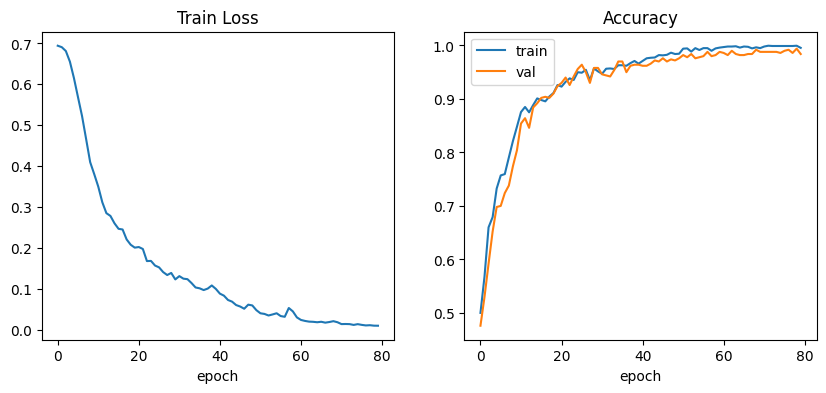

In [3]:

# train and evaluate
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total


train_losses = []
train_accs = []
val_accs = []

for ep in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(train_ds)
    train_acc = evaluate(model, train_loader)
    val_acc = evaluate(model, val_loader)
    train_losses.append(epoch_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    if ep % 10 == 0 or ep == 1:
        print(f"Epoch {ep}/{epochs}  loss={epoch_loss:.4f}  train_acc={train_acc:.4f}  val_acc={val_acc:.4f}")

# Save the model
torch.save(model.state_dict(), "tiny_parity_mlp.pth")
print("Saved model to tiny_parity_mlp.pth")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses); plt.title("Train Loss"); plt.xlabel("epoch")
plt.subplot(1,2,2)
plt.plot(train_accs, label='train'); plt.plot(val_accs, label='val'); plt.legend()
plt.title("Accuracy"); plt.xlabel("epoch")
plt.show()



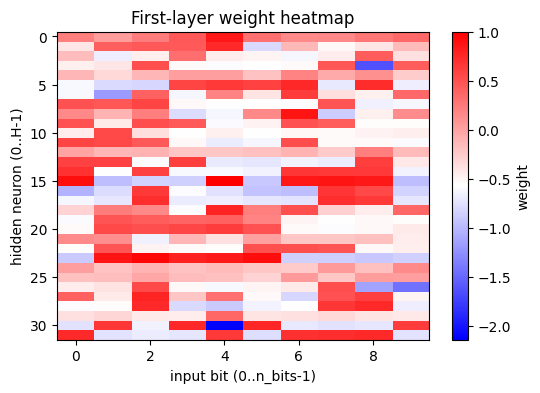

In [4]:
import torch
import matplotlib.pyplot as plt

W1 = model.net[0].weight.detach().cpu().numpy()

plt.figure(figsize=(6,4))
plt.imshow(W1, aspect='auto', cmap='bwr')
plt.colorbar(label='weight')
plt.xlabel('input bit (0..n_bits-1)')
plt.ylabel('hidden neuron (0..H-1)')
plt.title('First-layer weight heatmap')
plt.show()


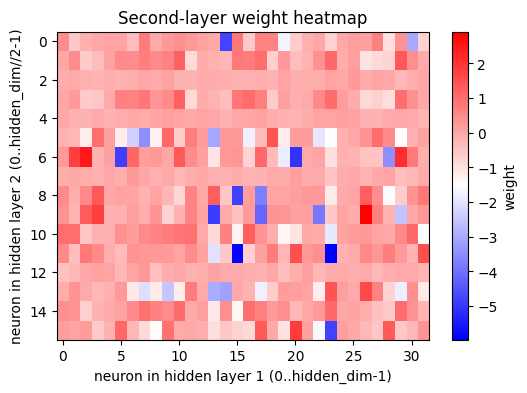

In [5]:
W2 = model.net[2].weight.detach().cpu().numpy()  # shape: [hidden_dim//2, hidden_dim]

plt.figure(figsize=(6,4))
plt.imshow(W2, aspect='auto', cmap='bwr')
plt.colorbar(label='weight')
plt.xlabel('neuron in hidden layer 1 (0..hidden_dim-1)')
plt.ylabel('neuron in hidden layer 2 (0..hidden_dim//2-1)')
plt.title('Second-layer weight heatmap')
plt.show()

In the first-layer weight heatmap, red, white, and blue regions appear relatively balanced, indicating that the network connections are sparse and selective.

Some neurons show alternating red and blue patterns across input bits, suggesting that they are detecting complex input combinations rather than relying on single bits.

In contrast, the second-layer weight heatmap is overall more red and smoothly distributed, implying that this layer primarily integrates and abstracts the information from the previous layer to form higher-level decision patterns.

✅ model loaded successfully.


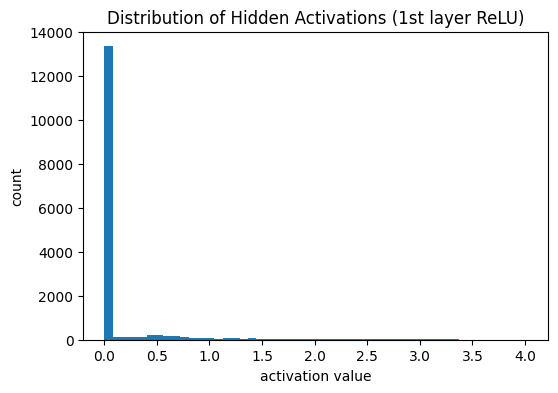

Dead ReLU rate: 0.819


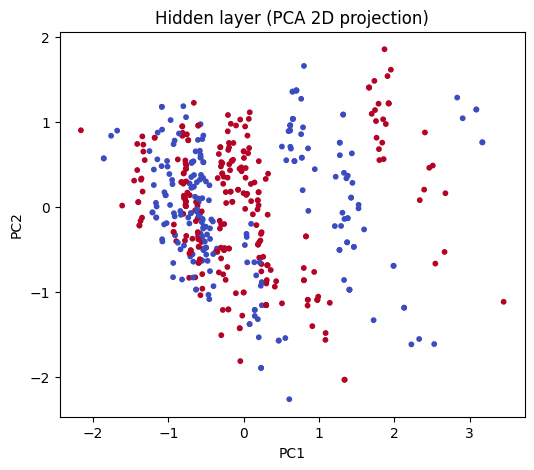

In [6]:
from sklearn.decomposition import PCA

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the model
class TinyMLP(nn.Module):
    def __init__(self, n_bits, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_bits, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 2)
        )
    def forward(self, x, return_hidden=False, which="first"):
        z1 = self.net[0](x)
        h1 = self.net[1](z1)
        z2 = self.net[2](h1)
        h2 = self.net[3](z2)
        out = self.net[4](h2)
        if return_hidden:
            return (out, h1) if which=="first" else (out, h2)
        return out

model = TinyMLP(n_bits=10, hidden_dim=32).to(device)
state = torch.load("tiny_parity_mlp.pth", map_location=device)
model.load_state_dict(state)
model.eval()
print("✅ model loaded successfully.")

# collect h1
all_h, all_y = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device).float()
        yb = yb.to(device)
        _, h = model(xb, return_hidden=True, which="first")
        all_h.append(h.cpu())
        all_y.append(yb)

H = torch.cat(all_h, dim=0).numpy()  # [N, hidden_dim]
Y = torch.cat(all_y, dim=0).numpy()  # [N]

# histgram
plt.figure(figsize=(6,4))
plt.hist(H.flatten(), bins=50)
plt.title("Distribution of Hidden Activations (1st layer ReLU)")
plt.xlabel("activation value"); plt.ylabel("count")
plt.show()

# ReLU
dead_rate = (H == 0).mean()
print(f"Dead ReLU rate: {dead_rate:.3f}")

# PCA visualization
pca = PCA(n_components=2)
H2 = pca.fit_transform(H)
plt.figure(figsize=(6,5))
plt.scatter(H2[:,0], H2[:,1], c=Y, s=10, cmap='coolwarm')
plt.title("Hidden layer (PCA 2D projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


The histogram shows that most of the activations in the first hidden layer are zero, indicating high sparsity caused by the ReLU nonlinearity.
Only a small subset of neurons respond strongly to the inputs, showing the selective activation.

In the PCA projection, samples of the two classes begin to form partially separated clusters, suggesting the first layer has begun to learn useful features for odd/even classification, but further abstraction by subsequent layers is still needed to complete the final classification.

In [8]:
import numpy as np
import torch

# Compute selectivity score (Cohen's d) for each neuron
scores = []
for j in range(H.shape[1]):
    h_j = H[:, j]
    m1 = h_j[Y==1].mean()
    m0 = h_j[Y==0].mean()
    s  = h_j.std() + 1e-8
    scores.append(abs(m1 - m0) / s)   # Cohen's d
rank = np.argsort(scores)[::-1]
print("Top-5 selective neurons (by Cohen's d):", rank[:5], " scores=", np.array(scores)[rank[:5]])

# Ablate (turn off) the most important neuron
target_j = int(rank[0])

# Find the first ReLU module
relu_module = None
for m in model.modules():
    # Find the first ReLU layer
    if isinstance(m, torch.nn.ReLU):
        relu_module = m
        break

def ablate_neuron_hook(module, inp, out):
    o = out.clone()
    o[:, target_j] = 0.0
    return o

handle = relu_module.register_forward_hook(lambda m, i, o: ablate_neuron_hook(m, i, o))

# valuate accuracy
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            yb = yb.to(device).long()
            logits = model(xb)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return correct / total

acc_ablate = evaluate(model, val_loader)
handle.remove()

acc_full = evaluate(model, val_loader)
print(f"Val acc (full) = {acc_full:.4f} | Val acc (ablate neuron {target_j}) = {acc_ablate:.4f} | Δacc = {acc_full-acc_ablate:.4f}")


Top-5 selective neurons (by Cohen's d): [22 29  7  3 27]  scores= [0.36412415 0.22751807 0.21563523 0.20846978 0.1963993 ]
Val acc (full) = 0.9840 | Val acc (ablate neuron 22) = 0.9820 | Δacc = 0.0020


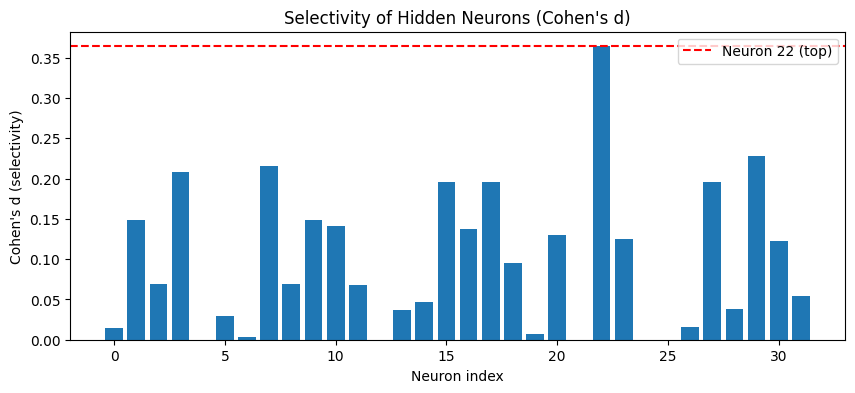

In [9]:
plt.figure(figsize=(10,4))
plt.bar(range(len(scores)), scores)
plt.xlabel("Neuron index")
plt.ylabel("Cohen's d (selectivity)")
plt.title("Selectivity of Hidden Neurons (Cohen's d)")
plt.axhline(scores[target_j], color='red', linestyle='--', label=f"Neuron {target_j} (top)")
plt.legend()
plt.show()

Using Cohen's d, I identified neuron 22 as the most class-selective unit in the first hidden layer (d>0.35), with a slightly higher activation difference between even and odd parity inputs.
However, ablating this neuron only reduced validation accuracy from 0.984 to 0.982 (Δacc=0.002), indicating that the network's representation is lhighly redundant/distributed and does not rely on a single “critical” neuron.
Neuron 22 appears to contribute to the decision, but its effect is modest.

**Reflection:**

By analyzing weights, activations, PCA projections, and neuron ablations, I learned that the model uses distributed representations rather than relying on a single “key” neuron: the first hidden layer shows sparse ReLU activations, and certain neurons are mildly selective for parity patterns.

I was suprised that after ablating the most selective neuron, the network remains stable.

What I want to understand further:
I would like to explore deeper layers and understand whether higher-level representations become more interpretable or more specialized. Additionally, I would love to explore different types of models to better understand how internal mechanism differ.

Citation: Code generated by ChatGPT 5.0 at 11.9 19:00 PM.